Author: Yann Charbon <yann.charbon@heig-vd.ch>

In [1]:
from DAGDatasetGenerator import DAGDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

generator = DAGDatasetGenerator()

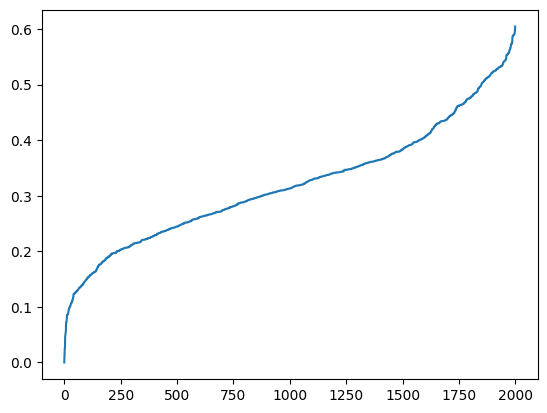

In [ ]:
dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=500, keep_random_dags=True, max_steps=2500)

perfs = np.asarray(perfs)
perfs = 1 - perfs / np.max(perfs)
dags = np.asarray(dags)
sorted_indices = np.argsort(perfs)
perfs_sorted = perfs[sorted_indices]
dags_sorted = dags[sorted_indices]

fig = plt.figure()
plt.plot(perfs_sorted)
plt.show()

In [35]:
def compute_empirical_perf(G: nx.DiGraph, adj_matrix):
    def get_nodes_at_rank(G: nx.DiGraph, rank: int):
        # Compute shortest path lengths from the source
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return [node for node, length in path_lengths.items() if length == rank]

    def get_max_rank(G: nx.DiGraph):
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return max(path_lengths.values())

    def compute_weighted_branching_factor(G: nx.DiGraph):
        score = 0
        rank = 0
        nodes_at_rank = get_nodes_at_rank(G, rank)
        while nodes_at_rank:
            for node in nodes_at_rank:
                children_count = len(list(G.successors(node)))
                if children_count > 1:
                    score += children_count
            rank += 1
            nodes_at_rank = get_nodes_at_rank(G, rank)
        return score

    def compute_global_branching_performance(G: nx.DiGraph, adj_matrix):
        global_branching_perf = 0
        for node in range(len(G.nodes)):
            branching_perf = 1
            children = list(G.successors(node))
            if not children:
                continue
            for child in children:
                branching_perf *= adj_matrix[node][child]
            if node > 0:
                parent = list(G.predecessors(node))[0]
                branching_perf *= adj_matrix[parent][node]
            global_branching_perf += branching_perf
        return global_branching_perf

    def compute_perf_for_one_node(node, G: nx.DiGraph, adj_matrix):
        rank = nx.shortest_path_length(G, target=node, source=0)
        done = False
        parent = 0
        child = node
        link_to_root_quality = 1.0
        cumulated_link_to_root_children_count = 0
        while not done:
            parent = list(G.predecessors(child))[0]
            if parent == 0:
                done = True
                break
            link_to_root_quality *= adj_matrix[parent][child]
            cumulated_link_to_root_children_count += len(list(G.successors(child)))
            child = parent
        children_count = len(list(G.successors(node)))
        return cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality

    total_nodes_count = len(G.nodes)

    path_sum_list = []
    global_children_count = 0
    global_rank = 0
    global_link_to_root_quality = 0

    for node in range(1, len(G.nodes)):
        cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality = compute_perf_for_one_node(node, G, adj_matrix)
        path_sum_list.append(cumulated_link_to_root_children_count)
        global_children_count += children_count
        global_rank += rank
        global_link_to_root_quality += link_to_root_quality

    # Normalize
    global_children_count_ratio = global_children_count / total_nodes_count

    # Ensure cumulated link-to-root children count ratio stays in [0,1]
    if len(path_sum_list) == 0:
        global_cumulated_link_to_root_children_count_ratio = 0
    else:
        max_path_sum = max(path_sum_list)
        if max_path_sum == 0:
            global_cumulated_link_to_root_children_count_ratio = 0
        else:
            total_path_sum = sum(path_sum_list)
            global_cumulated_link_to_root_children_count_ratio = total_path_sum / (len(path_sum_list) * max_path_sum)

    max_rank = get_max_rank(G)
    max_possible_rank_sum = total_nodes_count * max_rank
    global_rank_ratio = global_rank / max_possible_rank_sum if max_possible_rank_sum > 0 else 0
    global_link_to_root_quality_ratio = global_link_to_root_quality / total_nodes_count

    global_branching_factor_ratio = compute_weighted_branching_factor(G) / total_nodes_count
    global_max_rank_ratio = get_max_rank(G) / total_nodes_count
    global_branching_perf_ratio = compute_global_branching_performance(G, adj_matrix) / total_nodes_count

    return (
        global_children_count_ratio,
        global_cumulated_link_to_root_children_count_ratio,
        global_rank_ratio,
        global_link_to_root_quality_ratio,
        global_branching_factor_ratio,
        global_max_rank_ratio,
        global_branching_perf_ratio
    )

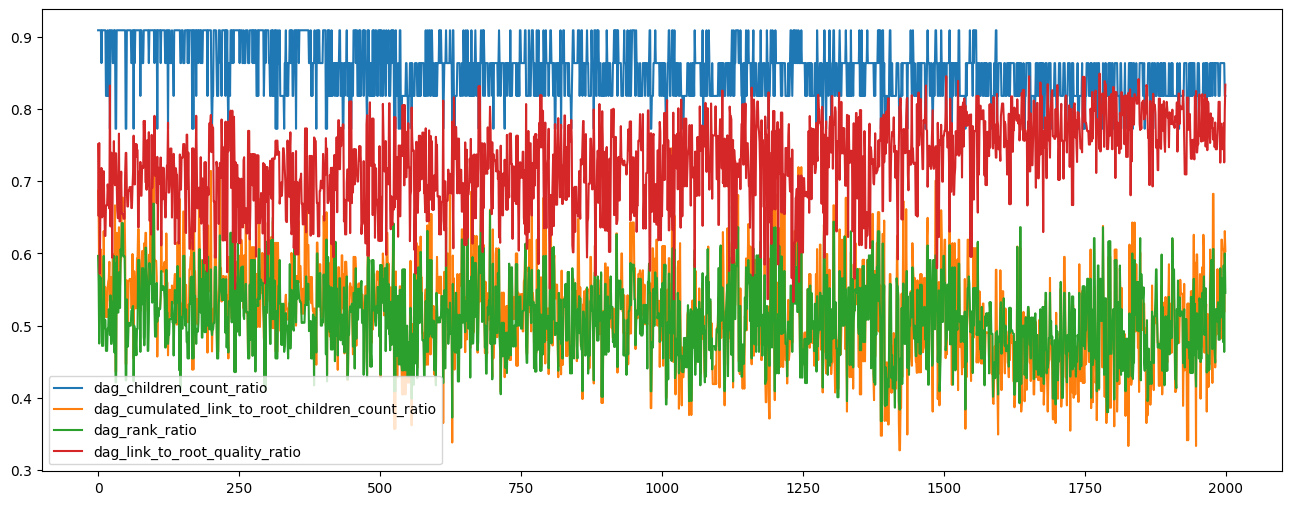

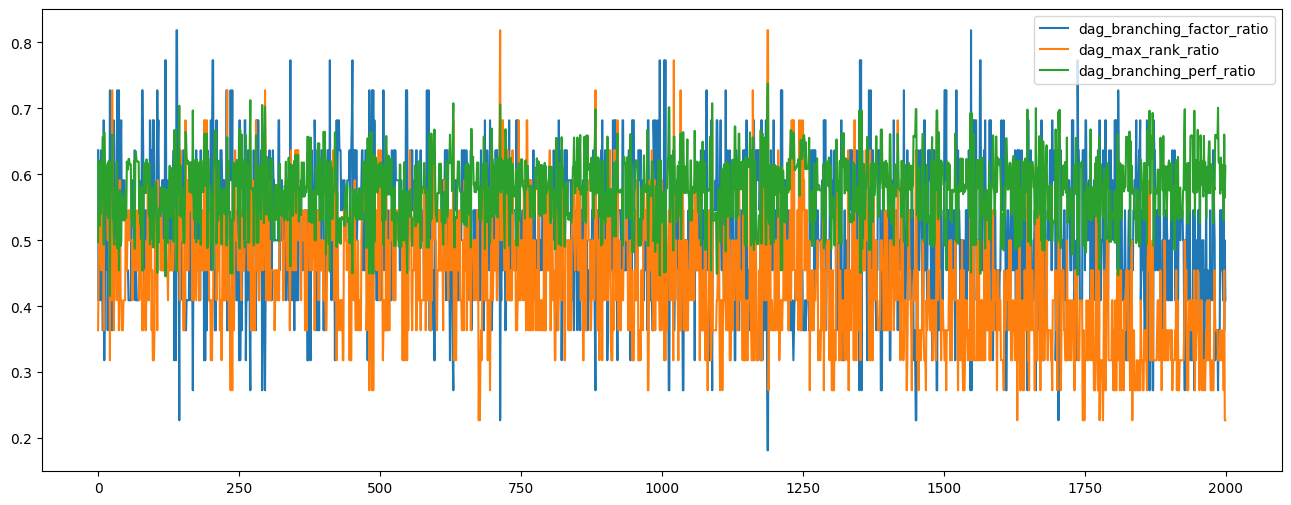

In [3]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []

for dag in dags:
    G = nx.DiGraph()
    G.add_edges_from(dag)

    (
        children_count_ratio,
        cumulated_link_to_root_children_count_ratio,
        rank_ratio,
        link_to_root_quality_ratio,
        branching_factor_ratio,
        max_rank_ratio,
        branching_perf_ratio
    ) = compute_empirical_perf(G, adj_matrix)

    # Append to lists
    dag_children_count_ratio.append(children_count_ratio)
    dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
    dag_rank_ratio.append(rank_ratio)
    dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
    dag_branching_factor_ratio.append(branching_factor_ratio)
    dag_max_rank_ratio.append(max_rank_ratio)
    dag_branching_perf_ratio.append(branching_perf_ratio)

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)

# Apply sorted indices
dag_children_count_ratio = dag_children_count_ratio[sorted_indices]
dag_cumulated_link_to_root_children_count_ratio = dag_cumulated_link_to_root_children_count_ratio[sorted_indices]
dag_rank_ratio = dag_rank_ratio[sorted_indices]
dag_link_to_root_quality_ratio = dag_link_to_root_quality_ratio[sorted_indices]
dag_branching_factor_ratio = dag_branching_factor_ratio[sorted_indices]
dag_max_rank_ratio = dag_max_rank_ratio[sorted_indices]
dag_branching_perf_ratio = dag_branching_perf_ratio[sorted_indices]


plt.figure(figsize=(16, 6))
plt.plot(dag_children_count_ratio, label="dag_children_count_ratio")
plt.plot(dag_cumulated_link_to_root_children_count_ratio, label="dag_cumulated_link_to_root_children_count_ratio")
plt.plot(dag_rank_ratio, label="dag_rank_ratio")
plt.plot(dag_link_to_root_quality_ratio, label="dag_link_to_root_quality_ratio")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_branching_factor_ratio, label="dag_branching_factor_ratio")
plt.plot(dag_max_rank_ratio, label="dag_max_rank_ratio")
plt.plot(dag_branching_perf_ratio, label="dag_branching_perf_ratio")
plt.legend()
plt.show()


In [9]:
# construct dataset

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib

Generated for topology 0
Generated for topology 1
Generated for topology 2
Generated for topology 3
Generated for topology 4
Generated for topology 5
Generated for topology 6
Generated for topology 7
Generated for topology 8
Generated for topology 9
Generated for topology 10
Generated for topology 11
Generated for topology 12
Generated for topology 13
Generated for topology 14
Generated for topology 15
Generated for topology 16
Generated for topology 17
Generated for topology 18
Generated for topology 19
Generated for topology 20
Generated for topology 21
Generated for topology 22
Generated for topology 23
Generated for topology 24
Generated for topology 25
Generated for topology 26
Generated for topology 27
Generated for topology 28
Generated for topology 29
Generated for topology 30
Generated for topology 31
Generated for topology 32
Generated for topology 33
Generated for topology 34
Generated for topology 35
Generated for topology 36
Generated for topology 37
Generated for topology

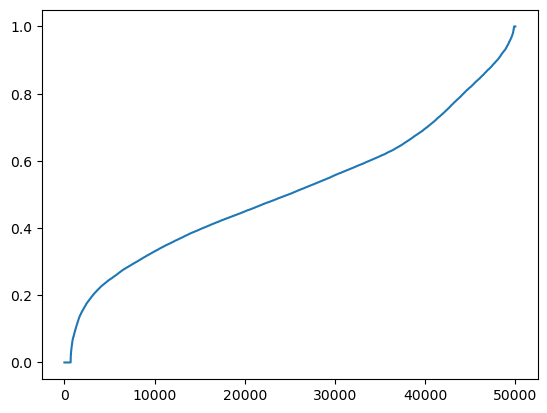

In [36]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []

all_perfs = []

for i in range(0, 100):
    dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=500, keep_random_dags=True, max_steps=2500)
    perfs -= np.min(perfs)
    perfs = 1 - perfs / np.max(perfs)   # normalize between 0 (worst) and 1 (best)
    for perf in perfs:
        all_perfs.append(perf)

    for dag in dags:
        G = nx.DiGraph()
        G.add_edges_from(dag)

        (
            children_count_ratio,
            cumulated_link_to_root_children_count_ratio,
            rank_ratio,
            link_to_root_quality_ratio,
            branching_factor_ratio,
            max_rank_ratio,
            branching_perf_ratio
        ) = compute_empirical_perf(G, adj_matrix)

        # Append to lists
        dag_children_count_ratio.append(children_count_ratio)
        dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
        dag_rank_ratio.append(rank_ratio)
        dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
        dag_branching_factor_ratio.append(branching_factor_ratio)
        dag_max_rank_ratio.append(max_rank_ratio)
        dag_branching_perf_ratio.append(branching_perf_ratio)

    print(f"Generated for topology {i}")

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)

all_perfs = np.array(all_perfs)

all_perfs_sorted_indices = np.argsort(all_perfs)

plt.figure()
plt.plot(all_perfs[all_perfs_sorted_indices])
plt.show()

In [37]:
n_samples = len(all_perfs)
n_features = 7

print(len(dag_children_count_ratio))
print(f"n_samples = {n_samples}, n_features = {n_features}")

X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples,))


for n in range(0, n_samples):
    X[n] = [dag_children_count_ratio[n], dag_cumulated_link_to_root_children_count_ratio[n], dag_rank_ratio[n], dag_link_to_root_quality_ratio[n], dag_branching_factor_ratio[n], dag_max_rank_ratio[n], dag_branching_perf_ratio[n]]
    y[n] = all_perfs[n]

joblib.dump(X, "X_empirical_2.dump")
joblib.dump(y, "y_empirical_2.dump")

50000
n_samples = 50000, n_features = 7


['y_empirical_2.dump']

In [21]:
X = joblib.load("X_empirical.dump")
y = joblib.load("y_empirical.dump")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

regr = MLPRegressor(hidden_layer_sizes=(2048, 1024, 512, 256), random_state=42, max_iter=100000, tol=0.0000001, learning_rate_init=0.0001, verbose=True)

regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Iteration 1, loss = 0.02104379
Iteration 2, loss = 0.01368245
Iteration 3, loss = 0.01251163
Iteration 4, loss = 0.01167323
Iteration 5, loss = 0.01096985
Iteration 6, loss = 0.01054063
Iteration 7, loss = 0.01012652
Iteration 8, loss = 0.00994547
Iteration 9, loss = 0.00968957
Iteration 10, loss = 0.00956497
Iteration 11, loss = 0.00963930
Iteration 12, loss = 0.00926279
Iteration 13, loss = 0.00911254
Iteration 14, loss = 0.00910557
Iteration 15, loss = 0.00912222
Iteration 16, loss = 0.00916613
Iteration 17, loss = 0.00899234
Iteration 18, loss = 0.00905031
Iteration 19, loss = 0.00895891
Iteration 20, loss = 0.00895522
Iteration 21, loss = 0.00890002
Iteration 22, loss = 0.00904043
Iteration 23, loss = 0.00899765
Iteration 24, loss = 0.00892872
Iteration 25, loss = 0.00878879
Iteration 26, loss = 0.00883744
Iteration 27, loss = 0.00880501
Iteration 28, loss = 0.00880589
Iteration 29, loss = 0.00888990


/home/yann/miniconda3/envs/dag-sim/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.6199542280966255

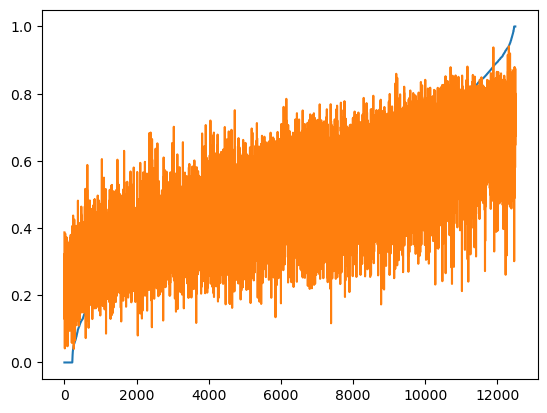

In [22]:
y_pred = regr.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_test[y_sorted_indices])
plt.plot(y_pred[y_sorted_indices])
plt.show()

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    # Create the model
    model = MLPRegressor(
        hidden_layer_sizes=(2048, 1024, 512, 256),
        activation="relu",
        solver=solver,
        learning_rate=learning_rate_method,
        max_iter=5000,
        tol=0.0000001,
        random_state=42,
        learning_rate_init=0.0001,
        verbose=True
    )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="MLP Regressor (2048, 1024, 512, 256) solver+learning_rate_method optimization", load_if_exists=True)
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

0.6431035231833473


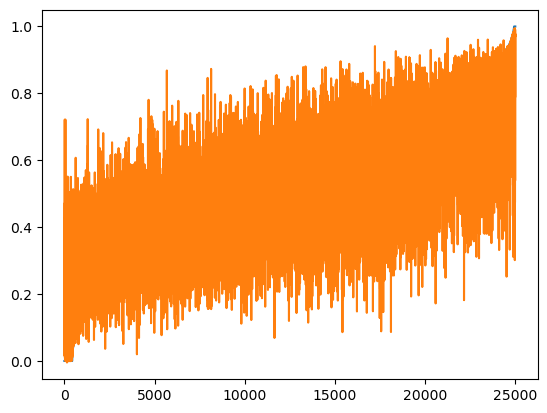

In [53]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib
import numpy as np
import matplotlib.pyplot as plt

X = joblib.load("X_empirical.dump")
y = joblib.load("y_empirical.dump")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

perf_model = XGBRegressor(n_estimators=4568, learning_rate=0.09984, max_depth=30, reg_lambda=1.0, reg_alpha=0.1, objective='reg:squarederror')
perf_model.fit(X_train, y_train)
print(perf_model.score(X_test, y_test))

y_pred = perf_model.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_test[y_sorted_indices])
plt.plot(y_pred[y_sorted_indices])
plt.show()

In [ ]:
# First model prediction confidence model
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score

y_diff = y_pred - y_test
y_conf = [1 if np.abs(sample) < 0.08 else 0 for sample in y_diff]

X_conf_train, X_conf_test, y_conf_train, y_conf_test = train_test_split(X_test, y_conf, random_state=42, test_size=0.2)

conf_model = XGBClassifier(n_estimators=4568, learning_rate=0.09984, max_depth=30)
conf_model.fit(X_conf_train, y_conf_train)

y_conf_pred = conf_model.predict_proba(X_conf_test)
y_conf_pred = [1 if pred[0] >= 0.5 else 0 for pred in y_conf_pred]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_conf_test, y_conf_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate recall score
recall = recall_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Recall score: {recall}")

# Calculate precision score
precision = precision_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Precision score: {precision}")

# Calculate F1 score
f1 = f1_score(y_conf_test, y_conf_pred, average='micro' )
print(f"F1 score: {f1}")

Mean Squared Error (MSE): 0.387
Recall score: 0.613
Precision score: 0.613
F1 score: 0.613


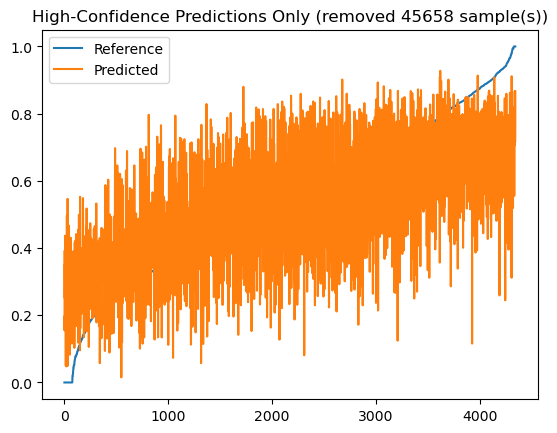

Filtered R² score: 0.4343003301041808


In [68]:
X_final_ref = joblib.load("X_empirical_2.dump")
y_final_ref = joblib.load("y_empirical_2.dump")

y_pred_unflt = perf_model.predict(X_final_ref)
y_conf_pred = conf_model.predict_proba(X_final_ref)
y_conf_pred = np.asarray([1 if pred[0] >= 0.98 else 0 for pred in y_conf_pred])

y_pred_flt = y_pred_unflt[y_conf_pred == 1]
y_final_ref_flt = y_final_ref[y_conf_pred == 1]

y_final_sorted_indices = np.argsort(y_final_ref_flt)

plt.figure()
plt.plot(y_final_ref_flt[y_final_sorted_indices], label='Reference')
plt.plot(y_pred_flt[y_final_sorted_indices], label='Predicted')
plt.legend()
plt.title(f"High-Confidence Predictions Only (removed {len(y_pred_unflt) - len(y_pred_flt)} sample(s))")
plt.show()

print("Filtered R² score:", r2_score(y_final_ref_flt, y_pred_flt))

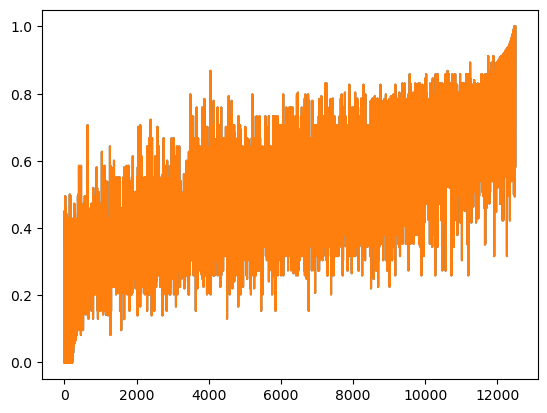

In [3]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1.0, increasing='auto')
y_pred_calibrated = iso_reg.fit_transform(y_pred, y_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_pred_calibrated[y_sorted_indices])
plt.plot(y_pred_calibrated[y_sorted_indices])
plt.show()

In [39]:
# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    #solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    #learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    n_estimators = trial.suggest_int("n_estimators", 500, 30000)
    learning_rate = trial.suggest_float("learning_rate_init", 0.00001, 0.1, log=True)
    n_estimators = trial.suggest_int("max_depth", 4, 30)

    # Create the model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=n_estimators)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="XGBRegressor1", load_if_exists=True)
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

[I 2025-03-20 22:39:57,940] A new study created in RDB with name: XGBRegressor1
[I 2025-03-20 22:39:58,126] Trial 0 finished with value: 0.01658185005255719 and parameters: {'n_estimators': 24620, 'learning_rate_init': 0.0017012144650942894, 'max_depth': 8}. Best is trial 0 with value: 0.01658185005255719.
[I 2025-03-20 22:39:59,851] Trial 1 finished with value: 0.27280148854528585 and parameters: {'n_estimators': 6890, 'learning_rate_init': 0.01452227322383302, 'max_depth': 18}. Best is trial 1 with value: 0.27280148854528585.
[I 2025-03-20 22:40:00,052] Trial 2 finished with value: 0.00011419402458368033 and parameters: {'n_estimators': 7582, 'learning_rate_init': 1.3290472907230197e-05, 'max_depth': 10}. Best is trial 1 with value: 0.27280148854528585.
[I 2025-03-20 22:40:00,215] Trial 3 finished with value: 0.47464701051538216 and parameters: {'n_estimators': 27419, 'learning_rate_init': 0.09869489698731086, 'max_depth': 7}. Best is trial 3 with value: 0.47464701051538216.
[I 2025-

KeyboardInterrupt: 